# Using signal processing and K-means clustering to extract and sort neural events in Python

This is the Python Jupyter Notebook for the Medium articles ([X](https://towardsdatascience.com/using-signal-processing-to-extract-neural-events-in-python-964437dc7c0) and [Y](https://towardsdatascience.com/whos-talking-using-k-means-clustering-to-sort-neural-events-in-python-e7a8a76f316)) on how to use signal processing techniques and K-means clustering to sort spikes.

### Part I
Code to read data from a .ncs file and extract the spike channel form the raw braod band signal through bandpass filtering. Also includes a function to extract and align spikes from the signal.


### Part II
Code to perform PCA on the extracted spike waveforms. Followed by a function that does K-means clustering on the PCA data to determine the number of clusters in the data and average waveforms according to their cluster number.

First we start with importing the libraries for reading in the data and processing it.

In [3]:
from scipy.signal import butter, lfilter
import numpy as np
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter Notebook
%matplotlib inline

Before we can start looking at the data (https://www2.le.ac.uk/centres/csn/software) we need to write a function to import the .ncs data format. You can check out the organization of the data format on the companies web page (https://neuralynx.com/software/NeuralynxDataFileFormats.pdf). The information provided there is the basis for the import routine below.

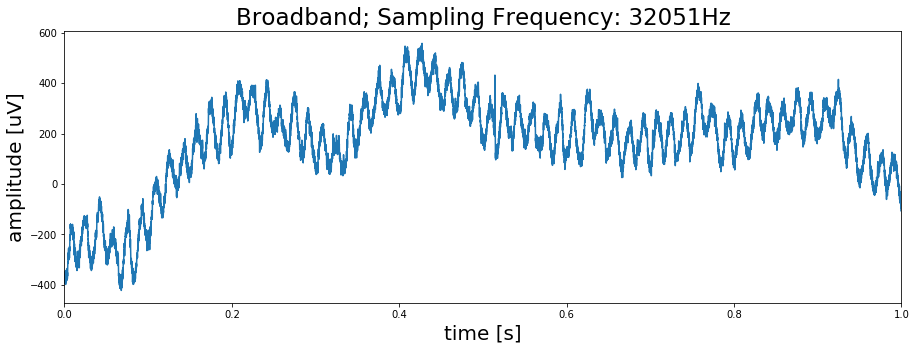

In [4]:
# Define data path
data_file = './UCLA_data/CSC4.Ncs'

# Header has 16 kilobytes length
header_size   = 16 * 1024  

# Open file
fid = open(data_file, 'rb')

# Skip header by shifting position by header size
fid.seek(header_size)

# Read data according to Neuralynx information
data_format = np.dtype([('TimeStamp', np.uint64),
                        ('ChannelNumber', np.uint32),
                        ('SampleFreq', np.uint32),
                        ('NumValidSamples', np.uint32),
                        ('Samples', np.int16, 512)])

raw = np.fromfile(fid, dtype=data_format)

# Close file
fid.close()

# Get sampling frequency
sf = raw['SampleFreq'][0]

# Create data vector
data = raw['Samples'].ravel()

# Determine duration of recording in seconds
dur_sec = data.shape[0]/sf

# Create time vector
time = np.linspace(0, dur_sec,data.shape[0])

# Plot first second of data
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(time[0:sf], data[0:sf])
ax.set_title('Broadband; Sampling Frequency: {}Hz'.format(sf), fontsize=23)
ax.set_xlim(0, time[sf])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)
plt.show()

# Part I

## Bandpass filter the data
As we can see the signal has strong 60Hz noise in it. The function below will bandpass filter the signal to exclude the 60Hz domain.

In [5]:
def filter_data(data, low, high, sf, order=2):
    # Determine Nyquist frequency
    nyq = sf/2

    # Set bands
    low = low/nyq
    high = high/nyq

    # Calculate coefficients
    b, a = butter(order, [low, high], btype='band')

    # Filter signal
    filtered_data = lfilter(b, a, data)
    
    return filtered_data

Using the above function lets us compare the raw data with the filtered signal

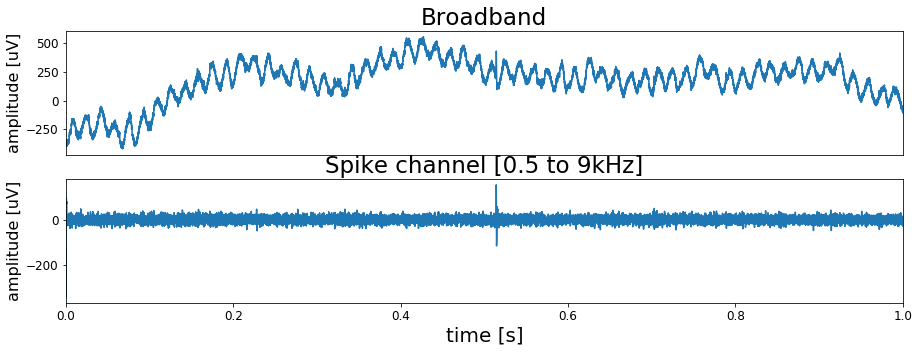

In [7]:
spike_data = filter_data(data, low=500, high=9000, sf=sf)

# Plot signals
fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].plot(time[0:sf], data[0:sf])
ax[0].set_xticks([])
ax[0].set_title('Broadband', fontsize=23)
ax[0].set_xlim(0, time[sf])
ax[0].set_ylabel('amplitude [uV]', fontsize=16)
ax[0].tick_params(labelsize=12)

ax[1].plot(time[0:sf], spike_data[0:sf])
ax[1].set_title('Spike channel [0.5 to 9kHz]', fontsize=23)
ax[1].set_xlim(0, time[sf])
ax[1].set_xlabel('time [s]', fontsize=20)
ax[1].set_ylabel('amplitude [uV]', fontsize=16)
ax[1].tick_params(labelsize=12)
plt.show()

## Interlude: LFP data processing

Here we will have a brief look at the LFP signal, the low frequency part of the recording. It is not relevant for the spike extraction or sorting so you might skip this section. However it will give you a better understanding about the nature of the recorded data.

In [36]:
from scipy import signal

# First lowpass filter the data to get the LFP signal
lfp_data = filter_data(data, low=1, high=300, sf=sf)

Because the LFP signal does not contain high frequency components anymore the original sampling rate can be reduced. This will lower the size of the data and speed up calculations. Therefore we define a short down-sampling function.

In [37]:
def downsample_data(data, sf, target_sf):
    factor = sf/target_sf
    if factor <= 10:
        data_down = signal.decimate(data, factor)
    else:
        factor = 10
        data_down = data
        while factor > 1:
            data_down = signal.decimate(data_down, factor)
            sf = sf/factor
            factor = int(min([10, sf/target_sf]))
    
    return data_down, sf

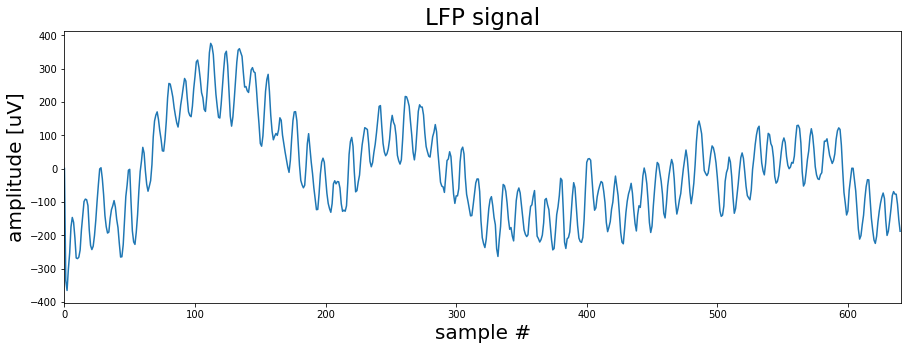

In [38]:
# Now we use the above function to downsample the signal.
lfp_data, sf_lfp = downsample_data(lfp_data, sf=sf, target_sf=600)

# Lets have a look at the downsampled LFP signal
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(lfp_data[0:int(sf_lfp)])
ax.set_title('LFP signal', fontsize=23)
ax.set_xlim([0, sf_lfp])
ax.set_xlabel('sample #', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)
plt.show()

As we already saw previously the signal is dominated by a strong 60Hz noise. If we wanted to continue working with the LFP signal this would be a problem. One way of dealing with this issue is to apply a notch filter that removes the 60Hz noise.
The code below sets up such a filter.

In [39]:
f0 = 60.0  # Frequency to be removed from signal (Hz)
w0 = f0/(sf_lfp/2)  # Normalized Frequency
Q = 30 # Quality factor

# Design notch filter
b, a = signal.iirnotch(w0, Q)

# Filter signal
clean_data = signal.lfilter(b, a, lfp_data)

Now before we apply the filter lets briefly check the filter properties. Mainly we are interested in how *sharp* the filter cuts the 60Hz and how does it influence the phase of the signal. Because in the end we only want to remove the noise and not alter the signal in other frequency domains.

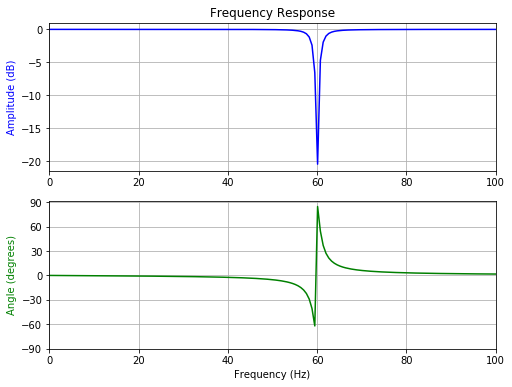

In [43]:
# Frequency response
w, h = signal.freqz(b, a)

# Generate frequency axis
freq = w*sf_lfp/(2*np.pi)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].grid()

ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
#ax[1].set_ylim([-90, 90])
ax[1].grid()
plt.show()

Ok seems like the filter should work. You can play around with the settings to see how the filter behaviour changes. But now lets see how the filtered sigal compares to the original LFP signal.

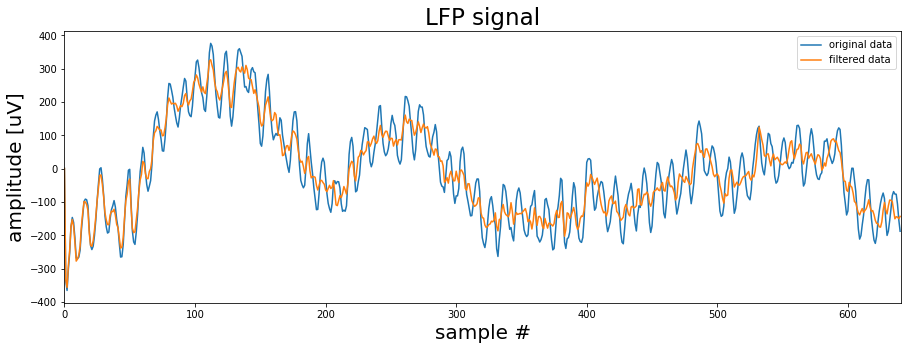

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(lfp_data[0:int(sf_lfp)], label='original data')
ax.plot(clean_data[0:int(sf_lfp)], label='filtered data')
ax.set_title('LFP signal', fontsize=23)
ax.set_xlim([0, sf_lfp])
ax.set_xlabel('sample #', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)

plt.legend()
plt.show()

This looks much better! As we can see the 60Hz is removed and we can now see other frequency signals riding on the very low frequency components.
Now finally, to check the effect of our notch filtering lets calculate the power spectra of the filtered and un-filtered signals.

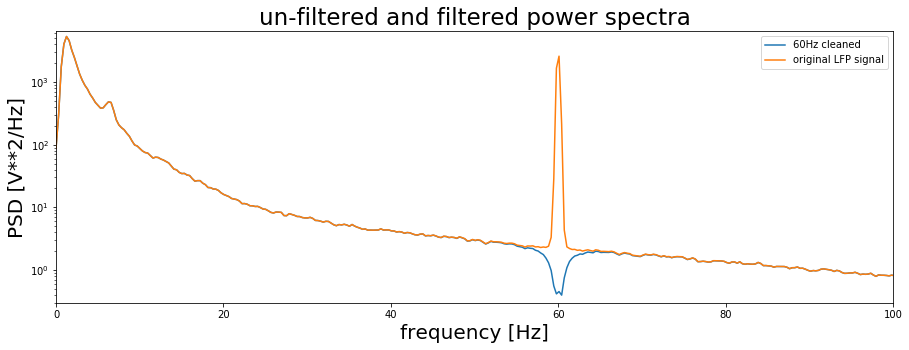

In [45]:
f, clean_data_power = signal.welch(clean_data, fs=sf_lfp, window='hanning', nperseg=2048, scaling='spectrum')
f, lfp_power = signal.welch(lfp_data, fs=sf_lfp, window='hanning', nperseg=2048, scaling='spectrum')

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.semilogy(f, clean_data_power, label='60Hz cleaned')
ax.semilogy(f, lfp_power, label='original LFP signal')
ax.set_title('un-filtered and filtered power spectra', fontsize=23)
ax.set_xlim([0, 100])
ax.set_ylim([.3, 6500])
ax.set_xlabel('frequency [Hz]', fontsize=20)
ax.set_ylabel('PSD [V**2/Hz]', fontsize=20)
ax.legend()

plt.show()

Clearly the filter removed the 60Hz band in the LFP and left the other frequencies intact. 
There are actually now many things we could do now with the LFP signal but this is a different topic. So lets get back to the spike channel and see how we can extract spikes from there.

## Extract spikes from the filtered signal
Now that we have a clean spike channel we can identify and extract spikes. The following function does that for us. It take five input arguments:

1. the filtered data 
1. the number of samples or window which should be extracted from the signal 
1. the threshold factor (mean(signal)*tf) 
1. an offset expressed in number of samples which shifts the maximum peak from the center 
1. the upper threshold which excludes data points above this limit to avoid extracting artifacts. 

In [19]:
def get_spikes(data, spike_window=80, tf=5, offset=10, max_thresh=350):
    
    # Calculate threshold based on data mean
    thresh = np.mean(np.abs(data)) *tf

    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0] 
    pos = pos[pos > spike_window]

    # Extract potential spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:i+spike_window*2]
            
            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) +i
                
                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp-(spike_window-offset):tmp_samp+(spike_window+offset)]

                # Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)
    
    # Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind]
    wave_form = wave_form[ind]
    
    return spike_samp, wave_form

Using the function on our filtered spike channel and plotting 100 randomly selected waveforms that were extracted.

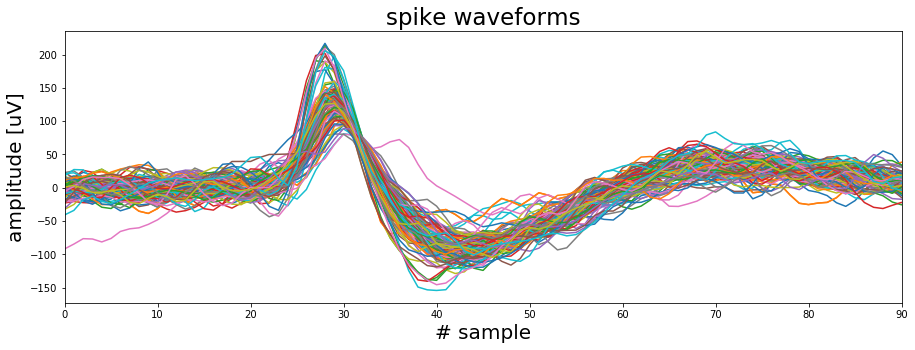

In [25]:
spike_samp, wave_form = get_spikes(spike_data, spike_window=50, tf=8, offset=20)

np.random.seed(10)
fig, ax = plt.subplots(figsize=(15, 5))

for i in range(100):
    spike = np.random.randint(0, wave_form.shape[0])
    ax.plot(wave_form[spike, :])

ax.set_xlim([0, 90])
ax.set_xlabel('# sample', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)
ax.set_title('spike waveforms', fontsize=23)
plt.show()

# Part II

## Reducing the number of dimensions with PCA
To cluster the waveforms we need some features to work with. A feature could be for example the peak amplitude of the spike or the width of the waveform. Another way to go is to use the principal components of the waveforms. Principal component analysis (PCA) is a dimensionality reduction method which requires normalized data. Here we will use Scikit Learn for both the normalization and the PCA. We will not go into the details of PCA here since the focus is the clustering.

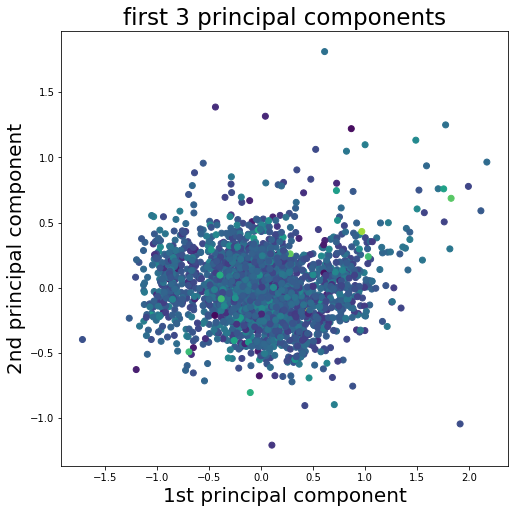

In [42]:
import sklearn as sk
from sklearn.decomposition import PCA

# Apply min-max scaling
scaler= sk.preprocessing.MinMaxScaler()
dataset_scaled = scaler.fit_transform(wave_form)

# Do PCA
pca = PCA(n_components=12)
pca_result = pca.fit_transform(dataset_scaled)

# Plot the 1st principal component aginst the 2nd and use the 3rd for color
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pca_result[:, 0], pca_result[:, 1], c=pca_result[:, 2])
ax.set_xlabel('1st principal component', fontsize=20)
ax.set_ylabel('2nd principal component', fontsize=20)
ax.set_title('first 3 principal components', fontsize=23)

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

The way we will implement K-means is quite straight forward. First, we choose a number of K random datapoints from our sample. These datapoints represent the cluster centers and their number equals the number of clusters. Next, we will calculate the Euclidean distance between all of the random cluster centers and any other datapoint. Then we assign each datapoint to the cluster center closest to it. Obviously doing all of this with random datapoints will not give us a good clustering result. So, we start over again. But this time we don't use random datapoints as cluster centers. Instead we calculate the actual cluster centers based on the previous random assignments and start the process again… and again… and again. With every iteration the datapoints that switch clusters will go down and we will arrive at a (hopefully) global optimum.

In [43]:
def k_means(data, num_clus=3, steps=200):

    # Convert data to Numpy array
    cluster_data = np.array(data)
    
    # Initialize by randomly selecting points in the data
    center_init = np.random.randint(0, cluster_data.shape[0], num_clus)

    # Create a list with center coordinates
    center_init = cluster_data[center_init, :]

    # Repeat clustering  x times
    for _ in range(steps):

        # Calculate distance of each data point to cluster center
        distance = []
        for center in center_init:
            tmp_distance = np.sqrt(np.sum((cluster_data - center)**2, axis=1))
            
            # Adding smalle random noise to the data to avoid matching distances to centroids
            tmp_distance = tmp_distance + np.abs(np.random.randn(len(tmp_distance))*0.0001)
            distance.append(tmp_distance)

        # Assign each point to cluster based on minimum distance
        _, cluster = np.where(np.transpose(distance == np.min(distance, axis=0)))

        # Find center of mass for each cluster
        center_init = []
        for i in range(num_clus):    
            center_init.append(cluster_data[cluster == i, :].mean(axis=0).tolist())
            
    return cluster, center_init, distance

So how should we choose the number of clusters? One way is to run our K-means function many times with different cluster numbers. The resulting plot shows the average inter-cluster distance. That is the average Euclidian distance between the datapoints of a cluster to the cluster center. From the plot we can see that after 4 to 6 clusters we do not see a strong decrease in the inter-cluster distance.

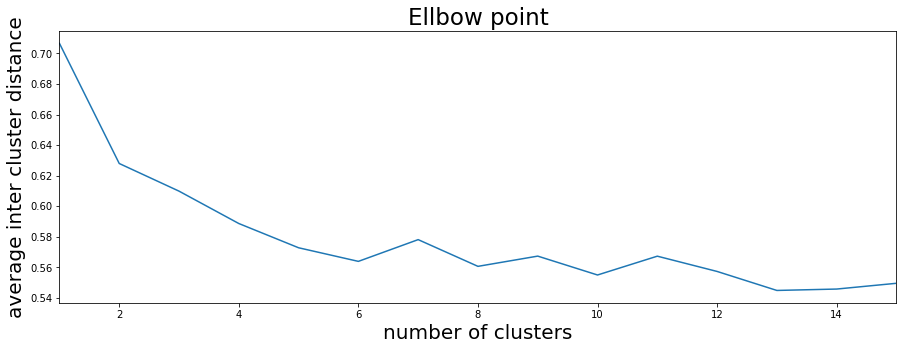

In [44]:
max_num_clusters = 15

average_distance = []
for run in range(20):
    tmp_average_distance = []
    for num_clus in range(1, max_num_clusters +1):
        cluster, centers, distance = k_means(pca_result, num_clus)
        tmp_average_distance.append(np.mean([np.mean(distance[x][cluster==x]) for x in range(num_clus)], axis=0))
    average_distance.append(tmp_average_distance)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(range(1, max_num_clusters +1), np.mean(average_distance, axis=0))
ax.set_xlim([1, max_num_clusters])
ax.set_xlabel('number of clusters', fontsize=20)
ax.set_ylabel('average inter cluster distance', fontsize=20)
ax.set_title('Ellbow point', fontsize=23)
plt.show()

So, let’s see what we get if we run the K-means algorithm with 6 cluster. Probably we could also go with 4 but let’s check the results with 6 first.

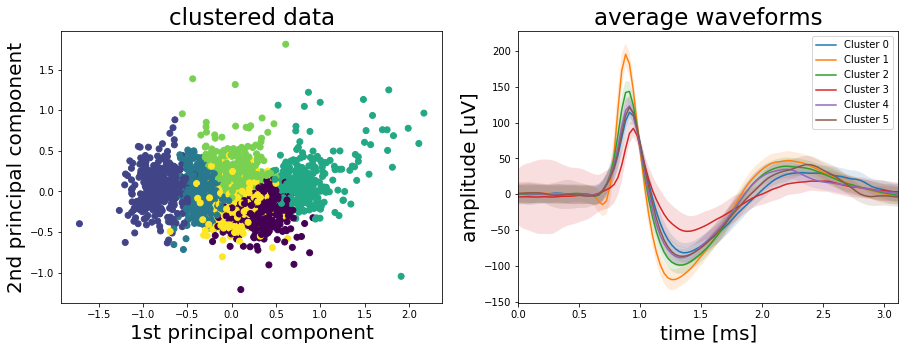

In [45]:
num_clus = 6
cluster, centers, distance = k_means(pca_result, num_clus)

# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(pca_result[:, 0], pca_result[:, 1], c=cluster)
ax[0].set_xlabel('1st principal component', fontsize=20)
ax[0].set_ylabel('2nd principal component', fontsize=20)
ax[0].set_title('clustered data', fontsize=23)

time = np.linspace(0, wave_form.shape[1]/sf, wave_form.shape[1])*1000
for i in range(num_clus):
    cluster_mean = wave_form[cluster==i, :].mean(axis=0)
    cluster_std = wave_form[cluster==i, :].std(axis=0)
    
    ax[1].plot(time, cluster_mean, label='Cluster {}'.format(i))
    ax[1].fill_between(time, cluster_mean-cluster_std, cluster_mean+cluster_std, alpha=0.15)

ax[1].set_title('average waveforms', fontsize=23)
ax[1].set_xlim([0, time[-1]])
ax[1].set_xlabel('time [ms]', fontsize=20)
ax[1].set_ylabel('amplitude [uV]', fontsize=20)

plt.legend()
plt.show()

Looking at above results it seems we chose to many clusters. The waveforms plot indicates that we may have extracted spikes from three different sources. Clusters 0, 1, 3 and 4 look like they have the same origin, while clusters 0 and 5 seem to be separate neurons. So, lets combine clusters 0, 1, 3 and 4.

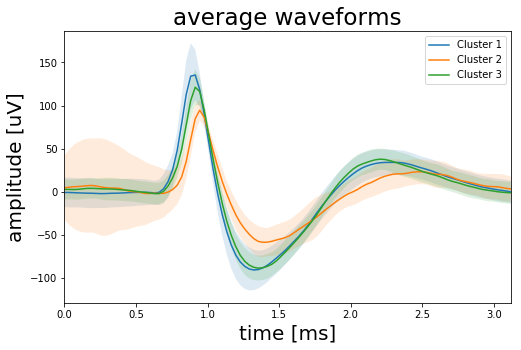

In [41]:
combine_clusters = [0, 1, 3, 4]
combined_waveforms_mean = wave_form[[x in combine_clusters for x in cluster], :].mean(axis=0)
combined_waveforms_std = wave_form[[x in combine_clusters for x in cluster], :].std(axis=0)

cluster_0_waveform_mean = wave_form[cluster==2, :].mean(axis=0)
cluster_0_waveform_std = wave_form[cluster==2, :].std(axis=0)

cluster_1_waveform_mean = wave_form[cluster==5, :].mean(axis=0)
cluster_1_waveform_std = wave_form[cluster==5, :].std(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(time, combined_waveforms_mean, label='Cluster 1')
ax.fill_between(time, combined_waveforms_mean-combined_waveforms_std, combined_waveforms_mean+combined_waveforms_std, 
                alpha=0.15)

ax.plot(time, cluster_0_waveform_mean, label='Cluster 2')
ax.fill_between(time, cluster_0_waveform_mean-cluster_0_waveform_std, cluster_0_waveform_mean+cluster_0_waveform_std, 
                alpha=0.15)

ax.plot(time, cluster_1_waveform_mean, label='Cluster 3')
ax.fill_between(time, cluster_1_waveform_mean-cluster_1_waveform_std, cluster_1_waveform_mean+cluster_1_waveform_std, 
                alpha=0.15)

ax.set_title('average waveforms', fontsize=23)
ax.set_xlim([0, time[-1]])
ax.set_xlabel('time [ms]', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)

plt.legend()
plt.show()